# LSTM Modelling 

In [16]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings("ignore")

## Data Refactor

In [17]:
dataset = pd.read_csv("../DateDatasets/dataset.csv").drop(columns=["Unnamed: 0"])

In [18]:
trips = pd.read_csv("../CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [19]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = np.delete(df, 2)

dataset = dataset.join(new_data)

In [20]:
dataset.to_csv("../DateDatasets/dataset.csv")

## Correlation Features

In [21]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 10436.527125289169),
 ('ATemp', 10280.850373783074),
 ('Year', 7092.1562101395475),
 ('Humidity', 4553.546738421971),
 ('Hour', 2521.675519475486),
 ('WeatherSituation', 1577.7531873242183),
 ('Day', 1020.0092383643951),
 ('StationEnd', 221.11531013433412),
 ('Windspeed', 189.9517425616836),
 ('Holiday', 56.248513129294146),
 ('Weekday', 47.644297362870226),
 ('WorkingDay', 39.98836012369895)]


## LSTM

In [40]:
epochs = 3
batch_size = 1
verbose = 2

MSE = [1.3783450722694397, 1.3512973546981812, 1.3557748436927795, 1.3466290950775146, 1.349846351146698]

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [23]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-06-30 17:39:46.259865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 17:39:46.261611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 17:39:46.263243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190913/190913 - 168s - loss: 1.4562 - accuracy: 0.3448 - 168s/epoch - 879us/step
Epoch 2/3
190913/190913 - 156s - loss: 1.4287 - accuracy: 0.3449 - 156s/epoch - 819us/step
Epoch 3/3
190913/190913 - 156s - loss: 1.4194 - accuracy: 0.3447 - 156s/epoch - 820us/step


2023-06-30 17:47:47.189157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 17:47:47.190205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 17:47:47.191247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
190911/190911 - 156s - loss: 1.4121 - accuracy: 0.3454 - 156s/epoch - 818us/step
Epoch 2/3
190911/190911 - 156s - loss: 1.4087 - accuracy: 0.3456 - 156s/epoch - 817us/step
Epoch 3/3
190911/190911 - 156s - loss: 1.4066 - accuracy: 0.3456 - 156s/epoch - 817us/step
Epoch 1/3
190601/190601 - 156s - loss: 1.4119 - accuracy: 0.3444 - 156s/epoch - 817us/step
Epoch 2/3
190601/190601 - 156s - loss: 1.4112 - accuracy: 0.3443 - 156s/epoch - 818us/step
Epoch 3/3
190601/190601 - 156s - loss: 1.4099 - accuracy: 0.3443 - 156s/epoch - 821us/step
Epoch 1/3
190628/190628 - 156s - loss: 1.4066 - accuracy: 0.3445 - 156s/epoch - 819us/step
Epoch 2/3
190628/190628 - 157s - loss: 1.4060 - accuracy: 0.3445 - 157s/epoch - 825us/step
Epoch 3/3
190628/190628 - 156s - loss: 1.4054 - accuracy: 0.3445 - 156s/epoch - 819us/step
Epoch 1/3
190698/190698 - 156s - loss: 1.4032 - accuracy: 0.3446 - 156s/epoch - 816us/step
Epoch 2/3
190698/190698 - 156s - loss: 1.4024 - accuracy: 0.3446 - 156s/epoch - 817us/step

Text(0.5, 0, 'Methods')

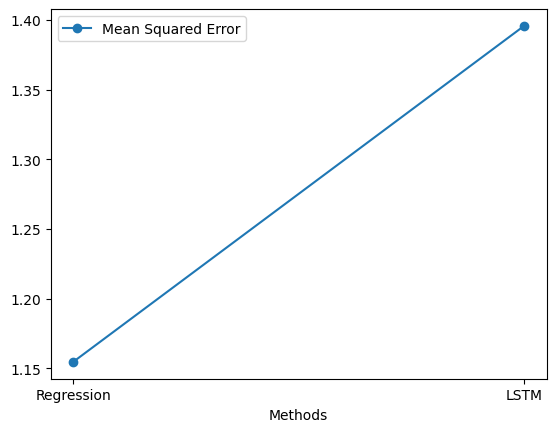

In [33]:
plt.plot(["Regression", "LSTM"], [1.1546453573093387, 1.395740568637848], marker="o")
plt.legend(["Mean Squared Error"])
plt.xlabel("Methods")

### Method 1
Input: ..., Temp

Output: c(t+1)

In [39]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-07-03 09:25:25.918519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 09:25:25.919450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 09:25:25.920089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190913/190913 - 171s - loss: 1.4496 - accuracy: 0.3446 - 171s/epoch - 894us/step
Epoch 2/3
190913/190913 - 165s - loss: 1.4165 - accuracy: 0.3451 - 165s/epoch - 865us/step
Epoch 3/3
190913/190913 - 165s - loss: 1.3991 - accuracy: 0.3450 - 165s/epoch - 864us/step


2023-07-03 09:33:46.903972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 09:33:46.905342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 09:33:46.906148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
190911/190911 - 167s - loss: 1.3884 - accuracy: 0.3459 - 167s/epoch - 873us/step
Epoch 2/3
190911/190911 - 170s - loss: 1.3823 - accuracy: 0.3459 - 170s/epoch - 890us/step
Epoch 3/3
190911/190911 - 166s - loss: 1.3782 - accuracy: 0.3459 - 166s/epoch - 869us/step
Epoch 1/3
190601/190601 - 164s - loss: 1.3788 - accuracy: 0.3447 - 164s/epoch - 858us/step
Epoch 2/3
190601/190601 - 167s - loss: 1.3762 - accuracy: 0.3447 - 167s/epoch - 877us/step
Epoch 3/3
190601/190601 - 166s - loss: 1.3742 - accuracy: 0.3446 - 166s/epoch - 869us/step
Epoch 1/3
190628/190628 - 161s - loss: 1.3718 - accuracy: 0.3448 - 161s/epoch - 846us/step
Epoch 2/3
190628/190628 - 167s - loss: 1.3707 - accuracy: 0.3447 - 167s/epoch - 878us/step
Epoch 3/3
190628/190628 - 173s - loss: 1.3697 - accuracy: 0.3448 - 173s/epoch - 908us/step
Epoch 1/3
190698/190698 - 168s - loss: 1.3686 - accuracy: 0.3448 - 168s/epoch - 883us/step
Epoch 2/3
190698/190698 - 160s - loss: 1.3668 - accuracy: 0.3448 - 160s/epoch - 837us/step

### Method 2
Input: ..., Temp, ATemp

Output: c(t+1)

In [26]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-06-30 20:15:29.099430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 20:15:29.100585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 20:15:29.101374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190913/190913 - 157s - loss: 1.4496 - accuracy: 0.3448 - 157s/epoch - 823us/step
Epoch 2/3
190913/190913 - 155s - loss: 1.3982 - accuracy: 0.3450 - 155s/epoch - 812us/step
Epoch 3/3
190913/190913 - 155s - loss: 1.3828 - accuracy: 0.3450 - 155s/epoch - 810us/step


2023-06-30 20:23:15.992899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 20:23:15.994080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 20:23:15.994797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
190911/190911 - 155s - loss: 1.3738 - accuracy: 0.3459 - 155s/epoch - 810us/step
Epoch 2/3
190911/190911 - 155s - loss: 1.3720 - accuracy: 0.3459 - 155s/epoch - 811us/step
Epoch 3/3
190911/190911 - 155s - loss: 1.3692 - accuracy: 0.3459 - 155s/epoch - 810us/step
Epoch 1/3
190601/190601 - 154s - loss: 1.3726 - accuracy: 0.3447 - 154s/epoch - 810us/step
Epoch 2/3
190601/190601 - 154s - loss: 1.3711 - accuracy: 0.3447 - 154s/epoch - 810us/step
Epoch 3/3
190601/190601 - 155s - loss: 1.3679 - accuracy: 0.3446 - 155s/epoch - 811us/step
Epoch 1/3
190628/190628 - 155s - loss: 1.3622 - accuracy: 0.3448 - 155s/epoch - 811us/step
Epoch 2/3
190628/190628 - 156s - loss: 1.3590 - accuracy: 0.3448 - 156s/epoch - 819us/step
Epoch 3/3
190628/190628 - 155s - loss: 1.3565 - accuracy: 0.3448 - 155s/epoch - 812us/step
Epoch 1/3
190698/190698 - 155s - loss: 1.3536 - accuracy: 0.3449 - 155s/epoch - 813us/step
Epoch 2/3
190698/190698 - 155s - loss: 1.3521 - accuracy: 0.3449 - 155s/epoch - 812us/step

### Method 3
Input: ..., Temp, ATemp, Humidity

Output: c(t+1)

In [27]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-06-30 21:32:53.554919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 21:32:53.556089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 21:32:53.557229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190913/190913 - 160s - loss: 1.4392 - accuracy: 0.3450 - 160s/epoch - 838us/step
Epoch 2/3
190913/190913 - 161s - loss: 1.3896 - accuracy: 0.3450 - 161s/epoch - 845us/step
Epoch 3/3
190913/190913 - 161s - loss: 1.3755 - accuracy: 0.3449 - 161s/epoch - 844us/step


2023-06-30 21:40:56.191190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 21:40:56.191980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 21:40:56.192941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
190911/190911 - 161s - loss: 1.3647 - accuracy: 0.3458 - 161s/epoch - 843us/step
Epoch 2/3
190911/190911 - 161s - loss: 1.3605 - accuracy: 0.3458 - 161s/epoch - 843us/step
Epoch 3/3
190911/190911 - 162s - loss: 1.3570 - accuracy: 0.3457 - 162s/epoch - 847us/step
Epoch 1/3
190601/190601 - 161s - loss: 1.3588 - accuracy: 0.3446 - 161s/epoch - 847us/step
Epoch 2/3
190601/190601 - 160s - loss: 1.3549 - accuracy: 0.3445 - 160s/epoch - 839us/step
Epoch 3/3
190601/190601 - 160s - loss: 1.3531 - accuracy: 0.3445 - 160s/epoch - 839us/step
Epoch 1/3
190628/190628 - 160s - loss: 1.3488 - accuracy: 0.3446 - 160s/epoch - 841us/step
Epoch 2/3
190628/190628 - 161s - loss: 1.3477 - accuracy: 0.3446 - 161s/epoch - 847us/step
Epoch 3/3
190628/190628 - 160s - loss: 1.3466 - accuracy: 0.3447 - 160s/epoch - 837us/step
Epoch 1/3
190698/190698 - 161s - loss: 1.3452 - accuracy: 0.3447 - 161s/epoch - 843us/step
Epoch 2/3
190698/190698 - 163s - loss: 1.3440 - accuracy: 0.3448 - 163s/epoch - 852us/step

### Method 4
Input: ..., Temp, ATemp, Humidity, WeatherSituation

Output: c(t+1)

In [28]:
dataset = pd.get_dummies(data=dataset, columns=["WeatherSituation"], dtype=int)

In [29]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-06-30 22:53:23.267572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 22:53:23.268678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 22:53:23.269376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190913/190913 - 168s - loss: 1.4397 - accuracy: 0.3450 - 168s/epoch - 877us/step
Epoch 2/3
190913/190913 - 167s - loss: 1.3926 - accuracy: 0.3450 - 167s/epoch - 874us/step
Epoch 3/3
190913/190913 - 166s - loss: 1.3809 - accuracy: 0.3448 - 166s/epoch - 870us/step


2023-06-30 23:01:44.073183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 23:01:44.074318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 23:01:44.075008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
190911/190911 - 165s - loss: 1.3703 - accuracy: 0.3455 - 165s/epoch - 863us/step
Epoch 2/3
190911/190911 - 166s - loss: 1.3637 - accuracy: 0.3455 - 166s/epoch - 869us/step
Epoch 3/3
190911/190911 - 167s - loss: 1.3611 - accuracy: 0.3456 - 167s/epoch - 876us/step
Epoch 1/3
190601/190601 - 168s - loss: 1.3643 - accuracy: 0.3444 - 168s/epoch - 879us/step
Epoch 2/3
190601/190601 - 167s - loss: 1.3636 - accuracy: 0.3444 - 167s/epoch - 875us/step
Epoch 3/3
190601/190601 - 167s - loss: 1.3618 - accuracy: 0.3443 - 167s/epoch - 878us/step
Epoch 1/3
190628/190628 - 165s - loss: 1.3581 - accuracy: 0.3446 - 165s/epoch - 868us/step
Epoch 2/3
190628/190628 - 167s - loss: 1.3547 - accuracy: 0.3447 - 167s/epoch - 874us/step
Epoch 3/3
190628/190628 - 167s - loss: 1.3528 - accuracy: 0.3447 - 167s/epoch - 877us/step
Epoch 1/3
190698/190698 - 166s - loss: 1.3505 - accuracy: 0.3447 - 166s/epoch - 872us/step
Epoch 2/3
190698/190698 - 167s - loss: 1.3482 - accuracy: 0.3447 - 167s/epoch - 877us/step

### Method 5
Input: ..., Temp, ATemp, Humidity, WeatherSituation, Windspeed

Output: c(t+1)

In [30]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Humidity", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-07-01 00:16:39.583988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 00:16:39.584916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 00:16:39.585646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190913/190913 - 172s - loss: 1.4385 - accuracy: 0.3447 - 172s/epoch - 902us/step
Epoch 2/3
190913/190913 - 169s - loss: 1.4025 - accuracy: 0.3450 - 169s/epoch - 887us/step
Epoch 3/3
190913/190913 - 169s - loss: 1.3875 - accuracy: 0.3450 - 169s/epoch - 885us/step


2023-07-01 00:25:10.462916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 00:25:10.463973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 00:25:10.464618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
190911/190911 - 170s - loss: 1.3767 - accuracy: 0.3459 - 170s/epoch - 889us/step
Epoch 2/3
190911/190911 - 169s - loss: 1.3696 - accuracy: 0.3459 - 169s/epoch - 888us/step
Epoch 3/3
190911/190911 - 170s - loss: 1.3660 - accuracy: 0.3459 - 170s/epoch - 889us/step
Epoch 1/3
190601/190601 - 168s - loss: 1.3692 - accuracy: 0.3447 - 168s/epoch - 879us/step
Epoch 2/3
190601/190601 - 167s - loss: 1.3648 - accuracy: 0.3447 - 167s/epoch - 879us/step
Epoch 3/3
190601/190601 - 168s - loss: 1.3591 - accuracy: 0.3446 - 168s/epoch - 880us/step
Epoch 1/3
190628/190628 - 169s - loss: 1.3539 - accuracy: 0.3447 - 169s/epoch - 885us/step
Epoch 2/3
190628/190628 - 170s - loss: 1.3514 - accuracy: 0.3447 - 170s/epoch - 892us/step
Epoch 3/3
190628/190628 - 168s - loss: 1.3499 - accuracy: 0.3447 - 168s/epoch - 881us/step
Epoch 1/3
190698/190698 - 168s - loss: 1.3478 - accuracy: 0.3448 - 168s/epoch - 879us/step
Epoch 2/3
190698/190698 - 168s - loss: 1.3469 - accuracy: 0.3447 - 168s/epoch - 883us/step

### Method 6
Input: ..., Temp, ATemp, WeatherSituation

Output: c(t+1)

In [36]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-07-03 09:18:46.125422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 09:18:46.126423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 09:18:46.127044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190913/190913 - 156s - loss: 1.4380 - accuracy: 0.3448 - 156s/epoch - 817us/step
Epoch 2/3


KeyboardInterrupt: 

## Graphs

Text(0.5, 0, 'Methods')

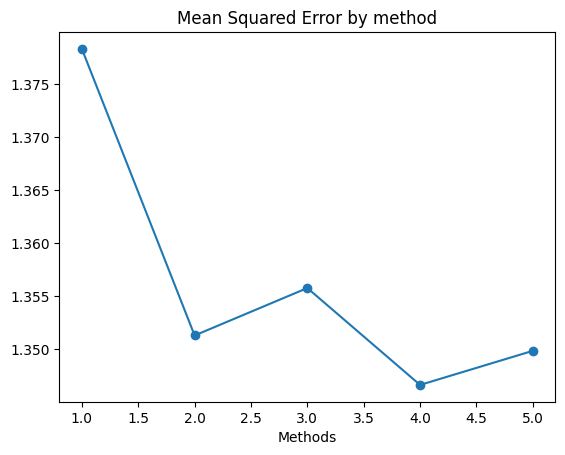

In [41]:
plt.plot(list(range(1,len(MSE)+1)), MSE, marker="o")
plt.title("Mean Squared Error by method")
plt.xlabel("Methods")

Text(0.5, 0, 'Methods')

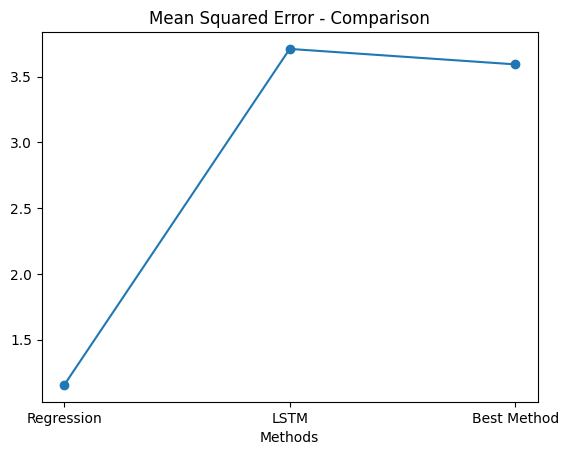

In [37]:
plt.plot(["Regression", "LSTM", "Best Method"], [1.1546453573093387, 3.7118978261947633, 3.5943119287490846], marker="o")
plt.title("Mean Squared Error - Comparison")
plt.xlabel("Methods")